# Judul : Prediksi Harga XAUUSD. 
#### Identitas : 
##### NIM : A11.2022.14532.
##### Nama : Najma Aura Dias Prameswari. 

# Ringkasan dan Permasalahan :
#### Ringkasan : 
Tujuan dari project ini adalah memprediksi harga XAUUSD (emas terhadap dolar AS), menggunakan model Long Short Term Memory (LSTM) dengan mengaplikasikan berbagai indikator teknis seperti MA, MACD, RSI dan lain sebagainya.

#### Permasalahan :
Bagaimana cara membuat model machine learning untuk memprediksi harga emas secara akurat menggunakan dataset historis dan indikator teknis?

# Penjelasan Dataset, Exploratory Data Analysis (EDA), dan Proses Features Dataset : 

#### Dataset : 
Dataset yang digunakan dalam project ini adalah dataset yang berisi data harga XAUUSD dengan atribut : 
1. Date
2. Time
3. Open
4. High
5. Low
6. Close
7. Volume

#### Proses Dataset : 
1. Data diolah dengan menggabungkan tanggal dan waktu menjadi kolom Datetime
2. Beberapa nilai yang hilang (NaN) dihapus
3. Dataset kemudian diubah menjadi format time series dengan Datetime sebagai indeks

# Proses Learning / Modeling : 
Model LSTM dirancang dengan regularisasi untuk menghindari overfitting:

##### Arsitektur : 
1. Dua lapisan LSTM dengan teknik regularisasi L2
2. Lapisan dropout untuk mencegah overfitting
3. Dense layer untuk menghasilkan output akhir

##### Callback : 
1. EarlyStopping untuk menghentikan pelatihan ketika tidak ada perbaikan
2. ReduceLROnPlateau untuk menyesuaikan laju pembelajaran jika pelatihan melambat

# Performa Model : 
Model dievaluasi menggunakan metrik : 
1. Mean Squared Error (MSE)
2. Mean Absolute Error (MAE)
3. R-Squared (R2)

# Diskusi Hasil dan Kesimpulan : 
Hasil evaluasi menunjukkan bahwa model mampu memprediksi harga emas dengan tingkat kesalahan yang kecil. Visualisasi menunjukkan perbandingan antara harga aktual dan harga prediksi, yang memberikan indikasi kuat akan performa model. 

In [38]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

In [39]:
# Membaca file data XAUUSD dan memprosesnya
file_path = r"C:\Users\HP\Documents\data mining\XAUUSD H1.csv"
data = pd.read_csv(file_path)

# Menambahkan nama kolom dataset
# Kolom ini berisi informasi seperti tanggal, waktu, harga pembukaan,
# harga tertinggi, harga terendah, harga penutupan dan volume
data.columns = ['Date', 'Time', 'Open', 'High', 'Low', 'Close', 'Volume']

# Menggabungkan kolom Date dan Time menjadi kolom Datetime
# untuk mempermudah analisis berbasis waktu
data['Datetime'] = pd.to_datetime(data['Date'] + ' ' + data['Time'])

# Memilih kolom yang relevan untuk analisis dan prediksi
data = data[['Datetime', 'Open', 'High', 'Low', 'Close', 'Volume']]

# Menjadikan kolom Datetime sebagai indeks untuk time series
data.set_index('Datetime', inplace=True)

# Menghapus baris dengan nilai kosong / null (jika ada)
data.dropna(inplace=True)

# Menampilkan informasi dataset dan 5 baris pertama verifikasi
print(data.info())
print(data.head())


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 82003 entries, 2010-01-04 00:00:00 to 2023-12-29 23:00:00
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    82003 non-null  float64
 1   High    82003 non-null  float64
 2   Low     82003 non-null  float64
 3   Close   82003 non-null  float64
 4   Volume  82003 non-null  float64
dtypes: float64(5)
memory usage: 3.8 MB
None
                        Open     High      Low    Close  Volume
Datetime                                                       
2010-01-04 00:00:00  1096.00  1096.90  1093.08  1094.49  3765.0
2010-01-04 01:00:00  1094.95  1095.95  1094.00  1095.65  3017.0
2010-01-04 02:00:00  1095.35  1099.15  1095.28  1097.87  3242.0
2010-01-04 03:00:00  1097.87  1099.64  1096.95  1098.89  2676.0
2010-01-04 04:00:00  1098.86  1102.75  1098.52  1101.60  2954.0


In [40]:
# mengambil harga penutupan dari dataset dan mengubahnya menjadi 
# array 2D dengan satu kolom, yang dibutuhkan untuk model
prices = data['Close'].values.reshape(-1, 1)
scaler = MinMaxScaler() # inisialisasi scaler untuk mengubah nilai menjadi rentang [0,1]
data_scaled = scaler.fit_transform(prices) # melakukan transformasi skala harga penutupan


In [41]:
# fungsi untuk membuat data sequence sebagai input model
# buat sequence
#  sequence membantu LSTM, memahami pola dari beberapa titik waktu sebelumnya
def create_sequences(data, sequence_length):
    x, y = [], []
    for i in range(sequence_length, len(data)):
        x.append(data[i-sequence_length:i, 0])  # megambil sequence_length data sebelumnya
        y.append(data[i, 0])  # Data target
    return np.array(x), np.array(y)

# menentukan panjang urutan (sequence_length)
sequence_length = 50
x, y = create_sequences(data_scaled, sequence_length)


In [42]:
# membagi data menjadi data pelatihan (80%) dan pengujian (20%)
train_size = int(len(x) * 0.8)
x_train, x_test = x[:train_size], x[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [43]:
# menambahkan dimensi fitur untuk data input yang sesuai dengan model LSTM
x_train = np.expand_dims(x_train, axis=-1)  
x_test = np.expand_dims(x_test, axis=-1)


In [44]:
# membuat model LSTM dengan regularisasi untuk mencegah overfitting 
input_shape = (sequence_length, x_train.shape[-1])
# model = Sequential([
#     Input(shape=(sequence_length, 1)),
#     LSTM(lstm_units, return_sequences=True, kernel_regularizer=regularizers.l2(0.001)),
#     BatchNormalization(),
#     Dropout(dropout_rate),
#     LSTM(lstm_units, return_sequences=False, kernel_regularizer=regularizers.l2(0.001)),
#     BatchNormalization(),
#     Dropout(dropout_rate),
#     Dense(25),
#     Dense(1)
# ])

model = Sequential([
    Input(shape=input_shape),
    LSTM(64, return_sequences=True, kernel_regularizer=regularizers.l2(0.001)),
    BatchNormalization(),
    Dropout(0.3),
    LSTM(64, return_sequences=False, kernel_regularizer=regularizers.l2(0.001)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(25, activation='relu'),
    Dense(1)
])

# menentukan optimizer dan fungsi loss
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='mean_squared_error')


In [45]:
# menyiapkan callbacks untuk meningkatkan performa pelatihan
# earlystopping untuk menghentikan pelatihan jika tidak ada perbaikan
# reducelronplateau untuk mengurangi learning rate jika pelatihan stagnan
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)


In [46]:
# melatih model menggunakan data pelatihan 
history = model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/50
2049/2049 ━━━━━━━━━━━━━━━━━━━━ 157s 71ms/step - loss: 0.4358 - val_loss: 0.0874 - learning_rate: 1.0000e-04
Epoch 2/50
2049/2049 ━━━━━━━━━━━━━━━━━━━━ 198s 69ms/step - loss: 0.1183 - val_loss: 0.0554 - learning_rate: 1.0000e-04
Epoch 3/50
2049/2049 ━━━━━━━━━━━━━━━━━━━━ 141s 69ms/step - loss: 0.0613 - val_loss: 0.0289 - learning_rate: 1.0000e-04
Epoch 4/50
2049/2049 ━━━━━━━━━━━━━━━━━━━━ 147s 71ms/step - loss: 0.0302 - val_loss: 0.0127 - learning_rate: 1.0000e-04
Epoch 5/50
2049/2049 ━━━━━━━━━━━━━━━━━━━━ 197s 68ms/step - loss: 0.0128 - val_loss: 0.0046 - learning_rate: 1.0000e-04
Epoch 6/50
2049/2049 ━━━━━━━━━━━━━━━━━━━━ 142s 69ms/step - loss: 0.0059 - val_loss: 0.0061 - learning_rate: 1.0000e-04
Epoch 7/50
2049/2049 ━━━━━━━━━━━━━━━━━━━━ 142s 69ms/step - loss: 0.0033 - val_loss: 0.0023 - learning_rate: 1.0000e-04
Epoch 8/50
2049/2049 ━━━━━━━━━━━━━━━━━━━━ 144s 70ms/step - loss: 0.0024 - val_loss: 7.3665e-04 - learning_rate: 1.0000e-04
Epoch 9/50
2049/2049 ━━━━━━━━━━━━━━━━━━━━ 20

In [47]:
# mengevaluasi performa model pada data pengujian
loss = model.evaluate(x_test, y_test)
print(f"Test Loss: {loss}")


513/513 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step - loss: 1.4085e-04
Test Loss: 0.00014831020962446928


513/513 ━━━━━━━━━━━━━━━━━━━━ 17s 31ms/step


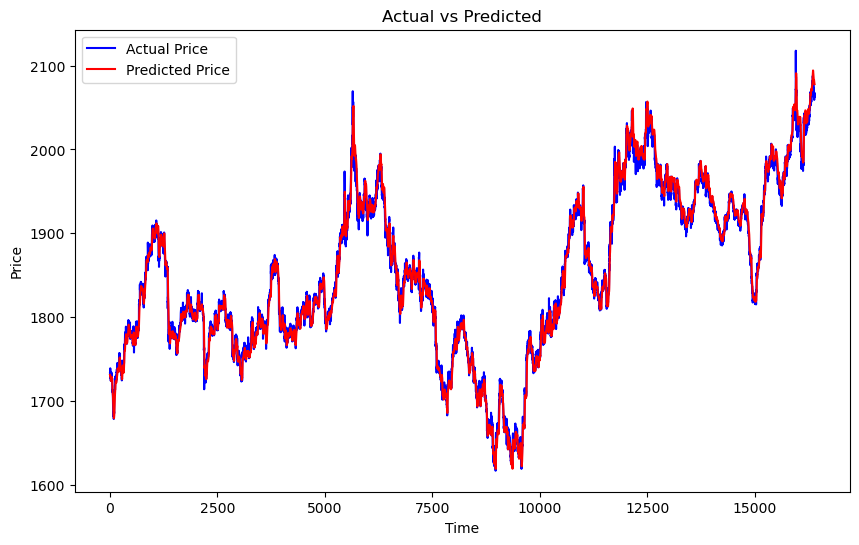

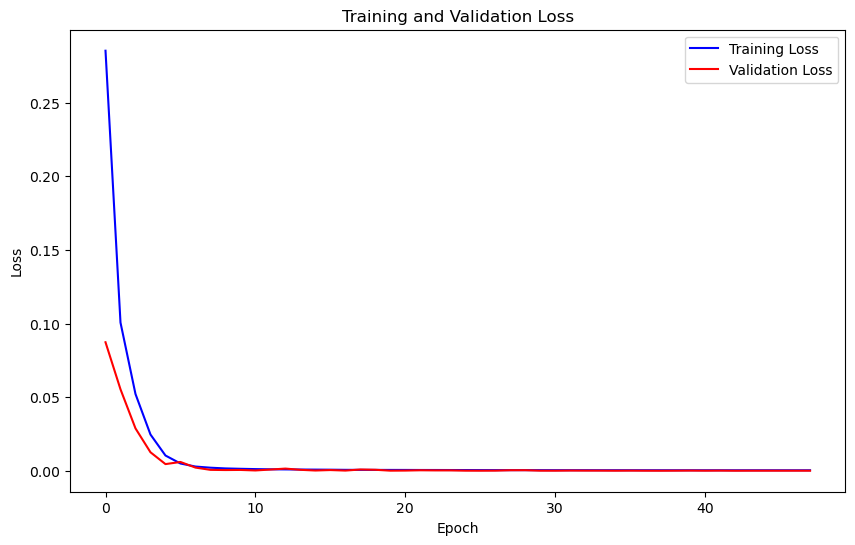

Mean Squared Error (MSE): 61.91462410389023
Mean Absolute Error (MAE): 5.688880958633931
R-squared (R²): 0.9934975010607247


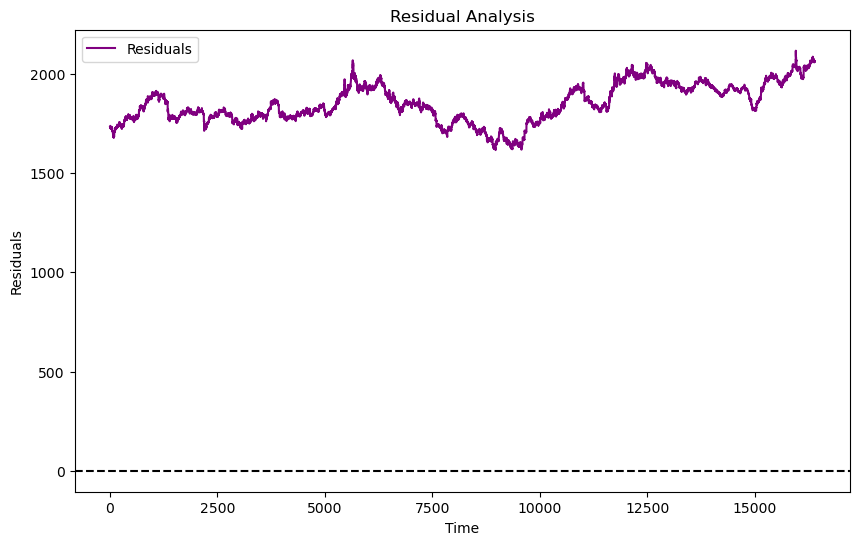

In [48]:
# fungsi untuk memvalidasi model dan menampilkan hasil prediksi
# meliputi visualisasi harga aktual vs prediksi, serta analisis metrik evaluasi
def validate_model(model, x_test, y_test, scaler):
    predictions = model.predict(x_test)
    predictions_rescaled = scaler.inverse_transform(predictions)
    y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

    # Visualize prediksi vs harga aktual 
    plt.figure(figsize=(10, 6))
    plt.plot(y_test_rescaled, label="Actual Price", color="blue")
    plt.plot(predictions_rescaled, label="Predicted Price", color="red")
    plt.title("Actual vs Predicted")
    plt.xlabel("Time")
    plt.ylabel("Price")
    plt.legend()
    plt.show()

    # visualisasi kerugian pelatihan vs validasi
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss', color='blue')
    plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
    plt.title("Training and Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    # menghitung metrik evaluasi : MSE, MAE, R - squared
    mse = mean_squared_error(y_test_rescaled, predictions_rescaled)
    mae = mean_absolute_error(y_test_rescaled, predictions_rescaled)
    r2 = r2_score(y_test_rescaled, predictions_rescaled)

    print(f"Mean Squared Error (MSE): {mse}")
    print(f"Mean Absolute Error (MAE): {mae}")
    print(f"R-squared (R²): {r2}")

    # analisis residuals
    residuals = y_test_rescaled - predictions
    plt.figure(figsize=(10, 6))
    plt.plot(residuals, label='Residuals', color='purple')
    plt.axhline(0, linestyle='--', color='black')
    plt.title('Residual Analysis')
    plt.xlabel('Time')
    plt.ylabel('Residuals')
    plt.legend()
    plt.show()

validate_model(model, x_test, y_test, scaler)

### Rumus: Moving Average (MA)

MA dihitung dengan rumus:
$$
MA = \frac{\sum_{i=1}^{N} Harga_i}{N}
$$
Di mana:
- $N$ adalah jumlah periode.
- $Harga_i$ adalah harga pada periode ke-$i$.


In [49]:
# menambahkan indikator teknikal pada dataset
# Moving Average (MA)
data['MA_10'] = data['Close'].rolling(window=10).mean()
data['MA_50'] = data['Close'].rolling(window=50).mean()

# MA_10 = rata - rata bergerak 10 hari, menunjukkan tren harga jangka pendek
# MA_50 = rata - rata bergerak 50 hari, menunjukkan tren harga jangka panjang

### Rumus: Moving Average Convergence Divergence (MACD)

MACD dihitung dengan rumus:
$$
MACD = EMA_{12} - EMA_{26}
$$

#### Signal Line:
$$
Signal\ Line = EMA_9(MACD)
$$
Di mana:
- $EMA_{12}$ adalah Exponential Moving Average untuk 12 periode.
- $EMA_{26}$ adalah Exponential Moving Average untuk 26 periode.
- $EMA_9(MACD)$ adalah rata-rata eksponensial dari nilai MACD selama 9 periode.


In [50]:
# Moving Average Convergence Divergence (MACD)
short_window = 12
long_window = 26
signal_window = 9

data['EMA_12'] = data['Close'].ewm(span=short_window, min_periods=1, adjust=False).mean()
data['EMA_26'] = data['Close'].ewm(span=long_window, min_periods=1, adjust=False).mean()
data['MACD'] = data['EMA_12'] - data['EMA_26']
data['Signal_Line'] = data['MACD'].ewm(span=signal_window, min_periods=1, adjust=False).mean()

# EMA_12 & EMA_26 = rata - rata eksponensial untuk jangka pendek (12 hari) dan jangka panjang (26 hari)
# MACD = selisih antara EMA jangka pendek dan panjang untuk mengukur momentum harga
# Signal Line = rata - rata eksponensial dari MACD digunakan untuk sinyal beli / jual

### Rumus: Rate of Change (ROC)

ROC dihitung dengan rumus:
$$
ROC = \frac{Harga\ Saat\ Ini - Harga\ N\ Periode\ Lalu}{Harga\ N\ Periode\ Lalu} \times 100
$$


In [51]:
# Rate of Change (ROC)
data['ROC_10'] = ((data['Close'] - data['Close'].shift(10)) / data['Close'].shift(10)) * 100

# ROC adalah indikator yang mengukur perubahan persentase harga selama periode tertentu
# data['Close'].shift(10): Mengambil harga penutupan dari 10 periode sebelumnya.
# ((data['Close'] - data['Close'].shift(10)) / data['Close'].shift(10)): Menghitung perubahan persentase dibandingkan harga 10 periode sebelumnya.
# * 100: Mengonversi hasil menjadi persentase.

### Rumus: Momentum
Momentum dihitung dengan rumus:
$$
Momentum = Harga\ Saat\ Ini - Harga\ N\ Periode\ Lalu
$$

In [52]:
# Momentum
data['Momentum'] = data['Close'] - data['Close'].shift(10)

# Momentum adalah indikator yang menghitung perbedaan harga saat ini dengan harga sebelumnya (N periode sebelumnya).
# data['Close'].shift(10): Mengambil harga penutupan dari 10 periode sebelumnya.
# data['Close'] - data['Close'].shift(10): Menghitung selisih antara harga saat ini dan 10 periode sebelumnya.

### Rumus: Relative Strength Index (RSI)

RSI dihitung dengan rumus:
$$
RSI = 100 - \frac{100}{1 + RS}
$$
Di mana:
$$
RS = \frac{Rata-rata\ Kenaikan}{Rata-rata\ Penurunan}
$$
- $Rata-rata\ Kenaikan$ adalah rata-rata kenaikan harga dalam $N$ periode terakhir.
- $Rata-rata\ Penurunan$ adalah rata-rata penurunan harga dalam $N$ periode terakhir.


In [53]:
# Relative Strength Index (RSI)
def calculate_RSI(data, window=14):
    delta = data['Close'].diff(1)
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    
    avg_gain = gain.rolling(window=window).mean()
    avg_loss = loss.rolling(window=window).mean()
    
    RS = avg_gain / avg_loss
    RSI = 100 - (100 / (1 + RS))
    return RSI

data['RSI_14'] = calculate_RSI(data)

# RSI mengukur kekuatan relatif harga untuk menentukan apakah harga sudah overbounght (>70) atau oversold (<30)

### Rumus: Bollinger Bands (BB)

Bollinger Bands dihitung dengan rumus:
- **Middle Band**:
$$
Middle\ Band = MA_{20}
$$
- **Upper Band**:
$$
Upper\ Band = Middle\ Band + 2 \times Standar\ Deviasi
$$
- **Lower Band**:
$$
Lower\ Band = Middle\ Band - 2 \times Standar\ Deviasi
$$
Di mana:
- $MA_{20}$ adalah Moving Average untuk 20 periode.
- $Standar\ Deviasi$ adalah standar deviasi harga selama 20 periode terakhir.


In [54]:
# Bollinger Bands (BB)
window = 20
data['BB_Middle'] = data['Close'].rolling(window=window).mean()
data['BB_Upper'] = data['BB_Middle'] + 2 * data['Close'].rolling(window=window).std()
data['BB_Lower'] = data['BB_Middle'] - 2 * data['Close'].rolling(window=window).std()

# BB menggunakan rata - rata bergerak tengah dan 2 standar deviasi untuk pita atas dan bawah
# membantu mengidentifikasi volatilitas pasar dan potensi breakout harga

$$
CCI = \frac{Typical\ Price - Rata-rata\ Typical\ Price}{0.015 \times Standar\ Deviasi\ Typical\ Price}
$$

$$
TP = \frac{High + Low + Close}{3}
$$


In [55]:
# Commodity Channel Index (CCI)
def calculate_CCI(data, window=20):
    TP = (data['High'] + data['Low'] + data['Close']) / 3
    rolling_mean_TP = TP.rolling(window=window).mean()
    rolling_std_TP = TP.rolling(window=window).std()
    
    CCI = (TP - rolling_mean_TP) / (0.015 * rolling_std_TP)
    return CCI

data['CCI_20'] = calculate_CCI(data)

# CCI adalah indikator yang mengukur deviasi harga dari rata-rata harga selama periode tertentu.
# rolling_mean_TP: Rata-rata TP untuk jangka waktu tertentu (20 periode).
# rolling_std_TP: Standar deviasi TP selama jangka waktu yang sama.
# (TP - rolling_mean_TP) / (0.015 * rolling_std_TP): Menghitung deviasi TP dari rata-ratanya.

In [56]:
# menghapus nilai NaN setelah perhitungan indikator teknikal
data.dropna(inplace=True)


In [57]:
# menampilkan dataset dengan indikator teknikal
print(data.head())


                        Open     High      Low    Close  Volume     MA_10  \
Datetime                                                                    
2010-01-06 01:00:00  1118.50  1122.05  1118.50  1122.05   677.0  1119.595   
2010-01-06 02:00:00  1122.15  1124.00  1120.95  1123.95   524.0  1119.615   
2010-01-06 03:00:00  1124.00  1124.80  1122.35  1123.00   507.0  1119.775   
2010-01-06 04:00:00  1123.00  1124.95  1122.90  1122.95   540.0  1120.320   
2010-01-06 05:00:00  1122.90  1124.40  1122.15  1122.90   603.0  1120.790   

                         MA_50       EMA_12       EMA_26      MACD  \
Datetime                                                             
2010-01-06 01:00:00  1117.0836  1120.184747  1119.869214  0.315534   
2010-01-06 02:00:00  1117.6728  1120.764017  1120.171494  0.592523   
2010-01-06 03:00:00  1118.2198  1121.108014  1120.381013  0.727001   
2010-01-06 04:00:00  1118.7214  1121.391397  1120.571308  0.820088   
2010-01-06 05:00:00  1119.2016  1121.623

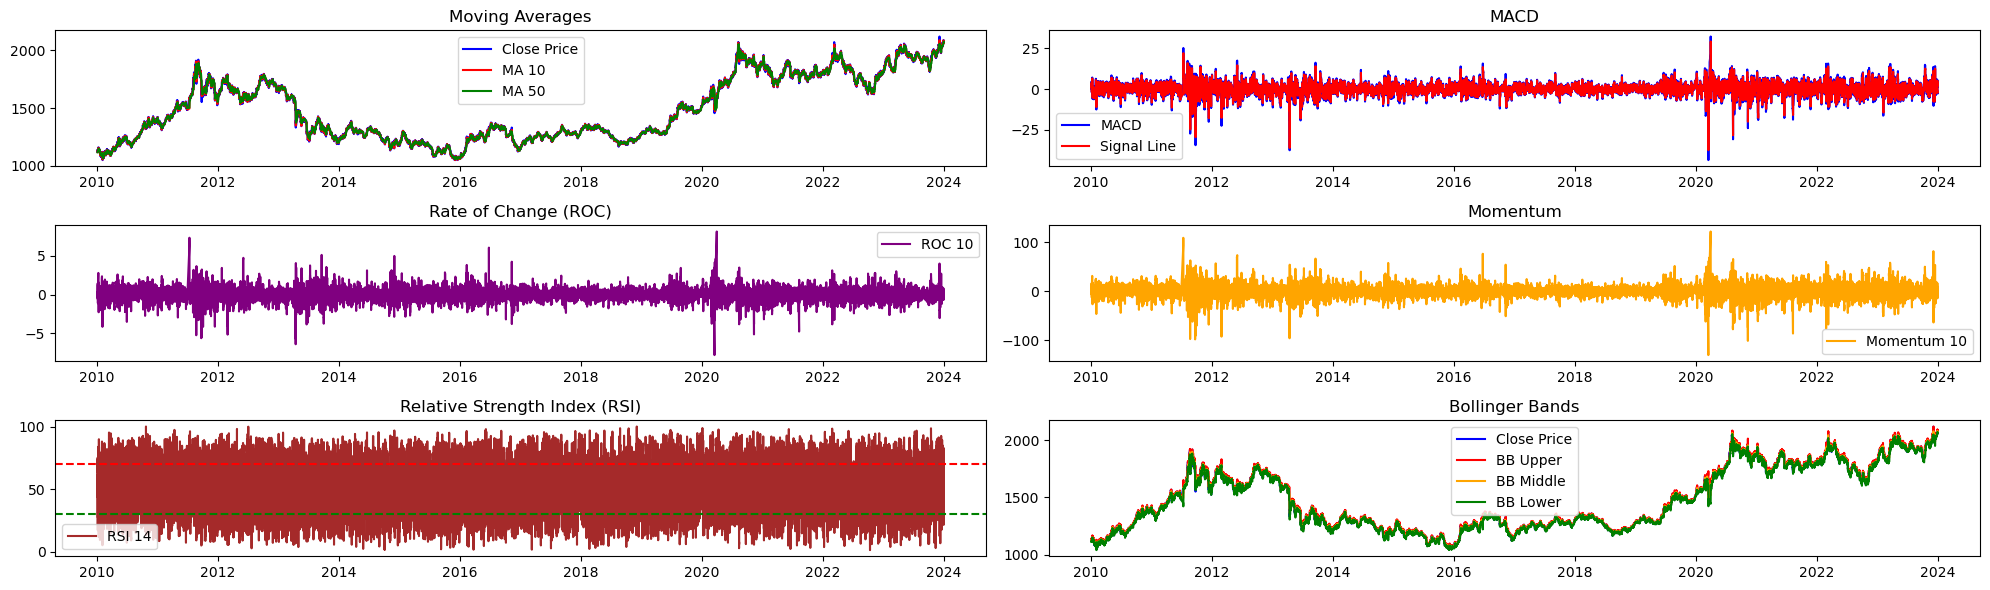

In [58]:
# visualisasi indikator teknikal
plt.figure(figsize=(20, 6))

# Plot MA
plt.subplot(3, 2, 1)
plt.plot(data['Close'], label='Close Price', color='blue')
plt.plot(data['MA_10'], label='MA 10', color='red')
plt.plot(data['MA_50'], label='MA 50', color='green')
plt.title('Moving Averages')
plt.legend()

# Plot MACD
plt.subplot(3, 2, 2)
plt.plot(data['MACD'], label='MACD', color='blue')
plt.plot(data['Signal_Line'], label='Signal Line', color='red')
plt.title('MACD')
plt.legend()

# Plot ROC
plt.subplot(3, 2, 3)
plt.plot(data['ROC_10'], label='ROC 10', color='purple')
plt.title('Rate of Change (ROC)')
plt.legend()

# Plot Momentum
plt.subplot(3, 2, 4)
plt.plot(data['Momentum'], label='Momentum 10', color='orange')
plt.title('Momentum')
plt.legend()

# Plot RSI
plt.subplot(3, 2, 5)
plt.plot(data['RSI_14'], label='RSI 14', color='brown')
plt.axhline(70, linestyle='--', color='red')
plt.axhline(30, linestyle='--', color='green')
plt.title('Relative Strength Index (RSI)')
plt.legend()

# Plot Bollinger Bands
plt.subplot(3, 2, 6)
plt.plot(data['Close'], label='Close Price', color='blue')
plt.plot(data['BB_Upper'], label='BB Upper', color='red')
plt.plot(data['BB_Middle'], label='BB Middle', color='orange')
plt.plot(data['BB_Lower'], label='BB Lower', color='green')
plt.title('Bollinger Bands')
plt.legend()

plt.tight_layout()
plt.show()

### Moving Average (MA)
1. Garis biru : Harga penutupan (close price)
2. Garis Merah (MA 10) : Rata - rata bergerak untuk 10 periode (menggambarkan tren jangka pendek)
3. Garis Hijau (MA 50) : Rata - rata bergerak untuk 50 periode (menggambarkan tren jangka panjang)

##### Interpretasi : 
1. Jika MA 10 berada di atas MA 50, maka menunjukkan tren naik (bullish)
2. Jika MA 10 berada di bawah MA 50, maka menunjukkan tren turun (brearish)
3. Persilangan antara garis MA 10 dan MA 50  sering digunakan sebagai sinyal beli / jual 


### Moving Average Convergence Divergence (MACD)
1. Garis biru (MACD) : Selisih antara EMA 12 dan EMA 26, yang menunjukkan momentum pasar
2. Garis Merah (Signal Line) : Rata - rata eksponensial dari MACD selama 9 periode

##### Interpretasi : 
1. Jika MACD memotong Signal Line dari bawah ke atas, itu adalah sinyal beli
2. Jika MACD memotong Signal Line dari atas ke bawah, itu adalah sinyal jual
3. Fluktuasi yang besar menunjukkan momentum harga yang tinggi, sedangkan fluktuasi kecil menunjukkan momentum harga yang rendah


### ROC (Rate of Change)
1. Garis Ungsu (ROC 10) : Perubahan persentase harga penutupan dibandingkan dengan 10 periode sebelumnya

##### Interpretasi : 
1. Jika ROC positif, harga saat ini lebih tinggi dibandingkan 10 periode sebelumnya,yag menunjukkan tren naik
2. Jika ROC negatif, harga saat ini lebih rendah dibandingkan 10 periode sebelumnya, yang menunjukkan tren turun
3. Puncak tajam menunjukkan perubahan harga yang signifikan dalam waktu singkat


### Momentum
1.Garis Oranye (Momentum 10) : Perbedaan harga penutupan saat ini dengan harga 10 periode sebelumnya

##### Interpretasi : 
1. Momentum positif menunjukkan tren naik
2. Momentum negatif menunjukkan tren turun
3. Puncak tajam menunjukkan perubahan harga yang kuat ke atas atau ke bawah


### Relative Strength Index (RSI)
1. Garis Merah : Batas overvbought (70)
2. Garis Hijau : Batas oversold (30)
3. Garis Coklat RSI (14) : RSI untuk 14 periode

##### Interpretasi : 
1. Jika RSI di atas 70, pasar dianggap overbought (kemungkinan pembalikan turun)
2. Jika RSI di bawah 30, pasar dianggap oversold (kemungkinan pembalikan naik)
3. RSI yang berfluktuasi diantara batas ini menunjukkan kondisi pasar yang stabil


### Bollinger Bands
1. Garis Bitu : Harga penutupan (close price)
2. Garis Merah (BB Upper) : Batas atas Bollinger Bands
3. Garis Hijau (BB Lower) : Batas bawah Bollinger Bands
4. Garis Oranye (BB Middle) : Rata - rata bergerak tengah

##### Interpretasi : 
1. Jika harga mendekati BB Upper, pasar overbought (kemungkinan koreksi turun)
2. Jika harga mendekati BB Lower, pasar oversold (kemungkinan koreksi naik)
3. Lebar pita BB mencerminkan volatilitas pasar. Lebih besar = lebih volatih, lebih sempit = lebih stabil


# Kesimpulan Umum : 
1. Menggunakan kombinasi indikator ini untuk mengidentifikasi tren, momentum, dan potensi pembalikan harga
2. Indikator seperti RSI & Bollinger Bands membantu mengonfirmasi sinyal beli / jual dari MA & MACD
3. Indikator teknikal ini lebih kuat jika digunakan bersama dengan analisis lainnya (seperti volume atau sentimen pasar)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Prediksi 4 Jam ke Depan: [[2077.5798]
 [2077.9814]
 [2078.8506]
 [2080.0186]]


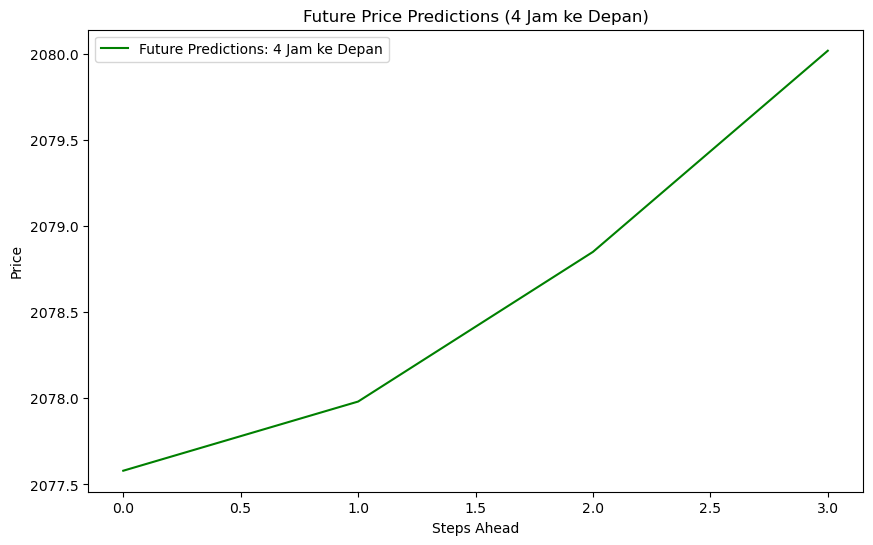

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
Prediksi 1 Hari ke Depan: [[2077.5798]
 [2077.9814]
 [2078.8506]
 [2080.0186]
 [2081.372

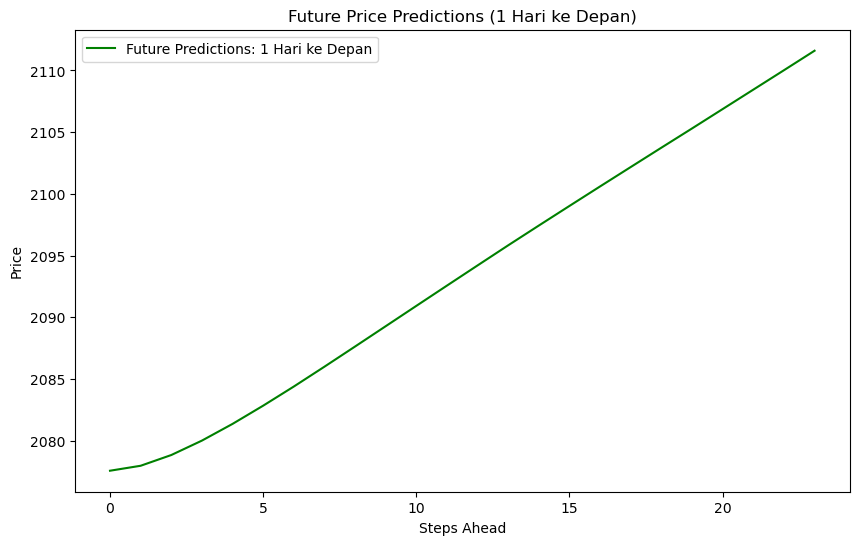

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━

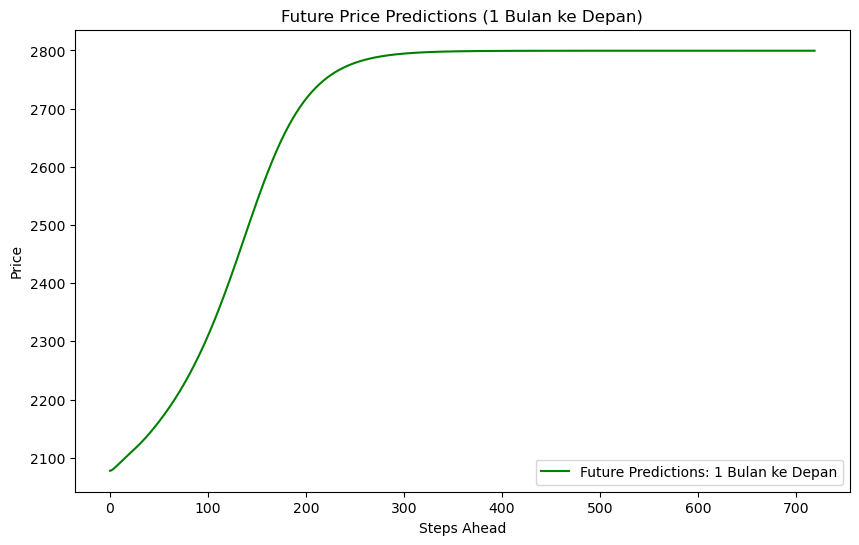

In [59]:
# Prediksi Langkah Ke Depan (4 jam, 1 hari, 1 bulan)
steps_mapping = {
    "4 Jam ke Depan": 4,
    "1 Hari ke Depan": 24,
    "1 Bulan ke Depan": 720
}

for label, steps_ahead in steps_mapping.items():
    last_sequence = data_scaled[-sequence_length:]
    last_sequence = np.expand_dims(last_sequence, axis=0)
    future_predictions = []

    for _ in range(steps_ahead):
        pred = model.predict(last_sequence)
        future_predictions.append(pred[0, 0])
        new_input = np.append(last_sequence[:, 1:, :], [[[pred[0, 0]]]], axis=1)
        last_sequence = new_input

    # Transformasi kembali prediksi
    future_predictions_rescaled = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))
    print(f"Prediksi {label}:", future_predictions_rescaled)

    # Visualisasi prediksi
    plt.figure(figsize=(10, 6))
    plt.plot(future_predictions_rescaled, label=f"Future Predictions: {label}", color="green")
    plt.title(f"Future Price Predictions ({label})")
    plt.xlabel("Steps Ahead")
    plt.ylabel("Price")
    plt.legend()
    plt.show()

# Prediksi 4 jam ke depan
1. Grafik: Prediksi harga meningkat secara perlahan selama 4 langkah ke depan.

##### Interpretasi : 
1. Model memprediksi bahwa harga akan terus naik secara bertahap.
2. Karena langkah prediksi hanya 4, tren yang terlihat cenderung linear dan tidak memperhitungkan fluktuasi besar.
3. Cocok untuk memprediksi perubahan harga jangka sangat pendek.


# Prediksi 1 Hari ke depan
1. Grafik: Prediksi harga menunjukkan kenaikan dengan kurva yang lebih jelas selama 24 langkah ke depan.

##### Interpretasi : 
1. Model memprediksi tren kenaikan yang stabil dalam jangka waktu 1 hari (24 langkah).
2. Grafik ini mencerminkan keyakinan model terhadap arah harga yang terus naik.
3. Fluktuasi kecil tidak terlihat karena data bersifat rata-rata untuk beberapa periode sebelumnya.


# Prediksi 1 Bulan ke depan
1. Grafik: Prediksi harga menunjukkan kenaikan yang sangat signifikan di awal, tetapi kemudian stabil mendekati titik tertentu.

##### Interpretasi : 
1. Prediksi menunjukkan kenaikan harga yang cepat hingga mencapai puncak pada sekitar langkah ke-300, kemudian mulai mendatar.
2. Stabilitas setelah langkah ke-300 mungkin menunjukkan bahwa model mengantisipasi batas alami untuk kenaikan harga.
3. Grafik ini sering kali dipengaruhi oleh asumsi model terhadap pola historis yang lebih panjang, dan perlu diverifikasi terhadap data nyata.

# Kesimpulan umum : 
1. Model menunjukkan tren kenaikan harga secara konsisten dalam semua periode prediksi.
2. Kekuatan Model:
- Untuk prediksi jangka pendek (4 jam, 1 hari), model memberikan prediksi yang lebih dapat diandalkan karena fluktuasi kecil lebih terkontrol.
- Untuk jangka panjang (1 bulan), model menunjukkan batas tertentu, tetapi hasilnya mungkin lebih spekulatif.
3. Catatan:
- Prediksi perlu divalidasi terhadap data nyata untuk memastikan akurasi.
- Faktor-faktor eksternal (seperti berita ekonomi atau geopolitik) yang tidak terlibat dalam model dapat memengaruhi hasil aktual.

In [60]:
# menyimpan model ke dalam file untuk penggunaan di masa depan
model.save('my_model.keras')


##### catatan code sebelum perubahan

In [61]:
# # Bersihkan dan proses data
# data.columns = ['Date', 'Time', 'Open', 'High', 'Low', 'Close', 'Volume']
# data['Datetime'] = pd.to_datetime(data['Date'] + ' ' + data['Time'])
# data = data[['Datetime', 'Open', 'High', 'Low', 'Close', 'Volume']]
# data.set_index('Datetime', inplace=True)
# data.dropna(inplace=True)

In [62]:
# data['Close'] = pd.to_numeric(data['Close'], errors='coerce')  # Pastikan kolom Close numeric


In [63]:
# Hyperparameters

# lstm_units = 64
# dropout_rate = 0.3
# epochs = 100
# batch_size = 32
# learning_rate = 0.0001

In [64]:

# # Menambahkan Batch Normalization
# model = Sequential([
#     Input(shape=(sequence_length, 1)),
#     LSTM(lstm_units, return_sequences=True),
#     BatchNormalization(),
#     Dropout(0.3),
#     LSTM(lstm_units, return_sequences=False),
#     BatchNormalization(),
#     Dropout(0.3),
#     Dense(25),
#     Dense(1)
# ])


In [65]:

# # Menggunakan regularisasi L2 pada LSTM layers
# model = Sequential([
#     Input(shape=(sequence_length, 1)),
#     LSTM(lstm_units, return_sequences=True, kernel_regularizer=regularizers.l2(0.001)),
#     Dropout(0.3),
#     LSTM(lstm_units, return_sequences=False, kernel_regularizer=regularizers.l2(0.001)),
#     Dropout(0.3),
#     Dense(25),
#     Dense(1)
# ])


In [66]:
# # Early stopping
# early_stopping = EarlyStopping(
#     monitor='val_loss',
#     patience=10,
#     restore_best_weights=True
# )


In [67]:
# # Prediksi
# predictions = model.predict(x_test)
# predictions = scaler.inverse_transform(predictions)
# y_test_scaled = scaler.inverse_transform(y_test.reshape(-1, 1))


In [68]:
# # Evaluasi
# plt.figure(figsize=(10, 6))
# plt.plot(y_test_scaled, label="Actual Price", color="blue")
# plt.plot(predictions, label="Predicted Price", color="red")
# plt.title("Forex Price Prediction")
# plt.xlabel("Time")
# plt.ylabel("Price")
# plt.legend()
# plt.show()

# plt.figure(figsize=(10, 6))
# plt.plot(history.history['loss'], label='Training Loss', color='blue')
# plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
# plt.title("Training and Validation Loss")
# plt.xlabel("Epoch")
# plt.ylabel("Loss")
# plt.legend()
# plt.show()


In [69]:

# # Hitung metrik evaluasi
# mse = mean_squared_error(y_test_scaled, predictions)
# mae = mean_absolute_error(y_test_scaled, predictions)
# r2 = r2_score(y_test_scaled, predictions)

# print(f"Mean Squared Error (MSE): {mse}")
# print(f"Mean Absolute Error (MAE): {mae}")
# print(f"R-squared (R²): {r2}")


In [70]:
# residuals = y_test_scaled - predictions
# plt.figure(figsize=(10, 6))
# plt.plot(residuals, label='Residuals', color='purple')
# plt.axhline(0, linestyle='--', color='black')
# plt.title('Residual Analysis')
# plt.xlabel('Time')
# plt.ylabel('Residuals')
# plt.legend()
# plt.show()

In [71]:
# last_sequence = data_scaled[-sequence_length:]  # Ambil window terakhir
# last_sequence = np.expand_dims(last_sequence, axis=0)  # Ubah bentuk
# future_prediction = model.predict(last_sequence)
# future_prediction = scaler.inverse_transform(future_prediction)
# print("Prediksi Harga Masa Depan / 8 tahun ke depan:", future_prediction)


In [72]:
# # Predict future prices
# steps_ahead = 4
# last_sequence = data_scaled[-sequence_length:]
# last_sequence = np.expand_dims(last_sequence, axis=0)  # Shape: (1, sequence_length, 1)
# future_predictions = []

# for _ in range(steps_ahead):
#     pred = model.predict(last_sequence)  # Shape: (1, 1)
#     future_predictions.append(pred[0, 0])  # Append the predicted value
#     # Prepare new input sequence
#     new_input = np.append(last_sequence[:, 1:, :], [[[pred[0, 0]]]], axis=1)  # Ensure 3D shape
#     last_sequence = new_input  # Update the sequence for the next prediction

# # Transform predictions back to original scale
# future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))
# print("Prediksi Harga 4 Langkah ke Depan:", future_predictions)
